In [1]:
import numpy as np
from scipy import special
from matplotlib import pyplot as plt

from matplotlib.animation import FuncAnimation
import seaborn as sns

import math

# import plotly.offline as pyo
# import plotly.graph_objects as go
# pyo.init_notebook_mode()
from IPython.display import HTML

from tqdm import tqdm
np.random.seed(1234)

In [14]:
P = np.array([[np.sqrt(3)/2, -1/2], [1/2, np.sqrt(3)/2]])
A = P @ np.diag([1,0.5]) @ np.linalg.inv(P)

def g(xz : np.array) -> np.array: # xz takes 2D array for individual point or 3D array
    return np.tanh(xz @ A.T) / 2


In [16]:
def f(x : np.array, z : np.array) -> np.array:
    return special.expit(- x - 2 * z + 0.5)

def f_parallelised(xz : np.array) -> np.array:
    return special.expit(xz @ [[-1],[-2]] + 0.5)

In [17]:
def simulate_all(n_neurons : int = 500, T : int = 10, max_time : int or None = None, 
                 n_paths : int = 20, max_point : int or None = 1000,
                 memorize : bool = True, rolling_mean : bool = False, store_xz : bool = False): 

    if (max_time is None):
        max_time = T * n_neurons

    print(f"case for n_neurons={n_neurons}, max_time={max_time}")

    sample = max_time // max_point
    time_arr = sample * torch.arange(max_point)
    max_time = sample * max_point # actual maximum time

    # initialise underlying chain and neural network parameters

    if memorize == True:
        B0 = np.random.uniform(0,1,size = (n_neurons, n_paths))
    else: 
        B0 = np.zeros((n_neurons, n_paths))

    W0 = np.random.normal(0,1,size = (n_neurons, n_paths))

    new_simulant_xz = np.random.uniform(-1,1,size=(n_paths,2))
    old_simulant_xz = new_simulant_xz
    new_simulant_h = special.expit(W0 * new_simulant_xz.T[0])
    old_simulant_h = new_simulant_h

    # simulation 
    # the arrays of (x,z) is of the format (steps, paths, dimension of entry = 2)
    # the array of memories are of the format (steps, neurons, paths)
    # for each step we first step through (x,z), then step through the memories 

    if store_xz == True:
        simulate_xz = np.zeros((max_point, n_paths, 2))
        simulate_xz[0] = old_simulant_xz
    
    if rolling_mean == True:
        simulate_sum_h = old_simulant_h
        simulate_sum_h2 = old_simulant_h ** 2

        simulate_avg_h = np.zeros((max_point, n_neurons, n_paths))
        simulate_avg_h2 = np.zeros((max_point, n_neurons, n_paths))

        print("now simulate the neurons, storing rolling mean")

        for k in tqdm(range(1, max_time - 1)):
            new_simulant_h = special.expit(W0 * old_simulant_xz.T[0] + np.sum(B0 * old_simulant_h, axis=0) / n_neurons)
            old_simulant_h = new_simulant_h
            simulate_sum_h += old_simulant_h
            simulate_sum_h2 += old_simulant_h ** 2
            new_simulant_xz = g(old_simulant_xz) + 0.5 * np.random.uniform(-1,1,size=(n_paths,2))
            old_simulant_xz = new_simulant_xz

            if k % sample == 0:
                simulate_avg_h[k // sample] = simulate_sum_h / k
                simulate_avg_h2[k // sample] = simulate_sum_h2 / k

                if store_xz == True: 
                    simulate_xz[k // sample] = old_simulant_xz

        if store_xz == True: 
            return simulate_avg_h, simulate_avg_h2, time_arr, simulate_xz
        else:
            return simulate_avg_h, simulate_avg_h2, time_arr

    else:
        simulate_h = np.zeros((max_point, n_neurons, n_paths))

        print("now simulate the neurons, storing history")

        for k in tqdm(range(1, max_time - 1)):
            new_simulant_h = special.expit(W0 * old_simulant_xz.T[0] + np.sum(B0 * old_simulant_h, axis=0) / n_neurons)
            new_simulant_xz = g(old_simulant_xz) + 0.5 * np.random.uniform(-1,1,size=(n_paths,2))
            old_simulant_h = new_simulant_h
            old_simulant_xz = new_simulant_xz

            if k % sample == 0:
                simulate_h[k // sample] = old_simulant_h

                if store_xz == True: 
                    simulate_xz[k // sample] = old_simulant_xz

        if store_xz == True: 
            return simulate_h, time_arr, simulate_xz
        else:
            return simulate_h, time_arr

In [18]:
simulate_avg_h, simulate_avg_h2, time_arr = simulate_all(n_neurons=10000, max_time=5000, n_paths=20, rolling_mean=True, memorize=True, store_xz=False)

case for n_neurons=10000, max_time=5000
now simulate the neurons, storing rolling mean


100%|██████████| 4998/4998 [00:09<00:00, 546.07it/s]


In [19]:
simulate_avg_h.shape

(1000, 10000, 20)

In [20]:
# test for one plot, averaging over all experiments and neurons

cumulative_mean_h = simulate_avg_h.reshape((simulate_avg_h.shape[0],-1))
cumulative_var_h = simulate_avg_h2.reshape((simulate_avg_h2.shape[0],-1))

In [21]:
overall_mean_mean_h = cumulative_mean_h.mean(axis=1)
overall_mean_std_h = cumulative_mean_h.std(axis=1)
overall_var_mean_h = cumulative_var_h.mean(axis=1)
overall_var_std_h = cumulative_var_h.std(axis=1)

1

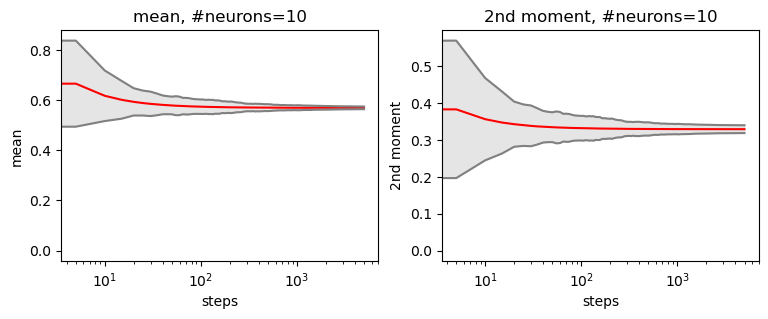

In [22]:
fig, ax = plt.subplots(ncols=2, figsize=(9,3))

# ax[0].plot(cumulative_mean_h.T[:1000])
ax[0].plot(time_arr, overall_mean_mean_h, color="red")
ax[0].plot(time_arr, overall_mean_mean_h - 2 * overall_mean_std_h, color="grey")
ax[0].plot(time_arr, overall_mean_mean_h + 2 * overall_mean_std_h, color="grey")
ax[0].fill_between(time_arr, 
                    overall_mean_mean_h - 2 * overall_mean_std_h, 
                    overall_mean_mean_h + 2 * overall_mean_std_h, 
                    color="grey", alpha=0.2)
ax[0].set_xscale("log")
ax[0].set_xlabel("steps")
ax[0].set_ylabel("mean")
ax[0].set_title("mean, #neurons=10")

ax[1].plot(time_arr, overall_var_mean_h, color="red")
ax[1].plot(time_arr, overall_var_mean_h - 2 * overall_var_std_h, color="grey")
ax[1].plot(time_arr, overall_var_mean_h + 2 * overall_var_std_h, color="grey")
ax[1].fill_between(time_arr, 
                    overall_var_mean_h - 2 * overall_var_std_h, 
                    overall_var_mean_h + 2 * overall_var_std_h, 
                    color="grey", alpha=0.2)
ax[1].set_xscale("log")
ax[1].set_xlabel("steps")
ax[1].set_ylabel("2nd moment")
ax[1].set_title("2nd moment, #neurons=10")
1

Further visualisation

In [27]:
sample=10
cumulative_mean_h, cumulative_var_h = get_cumulative_moments(simulate_h, sample=sample)

overall_cumulative_mean_h = cumulative_mean_h.reshape((-1,cumulative_mean_h.shape[2])).mean(axis=0)
lower_mean_h = cumulative_mean_h.mean(axis=1).min(axis=0)
upper_mean_h = cumulative_mean_h.mean(axis=1).max(axis=0)
union_lower_mean_h = (cumulative_mean_h.mean(axis=1) - 2 * cumulative_mean_h.std(axis=1)).min(axis=0)
union_upper_mean_h = (cumulative_mean_h.mean(axis=1) + 2 * cumulative_mean_h.std(axis=1)).max(axis=0)

overall_cumulative_var_h = cumulative_var_h.reshape((-1,cumulative_var_h.shape[2])).mean(axis=0)
lower_var_h = cumulative_var_h.mean(axis=1).min(axis=0)
upper_var_h = cumulative_var_h.mean(axis=1).max(axis=0)
union_lower_var_h = (cumulative_var_h.mean(axis=1) - 2 * cumulative_var_h.std(axis=1)).min(axis=0)
union_upper_var_h = (cumulative_var_h.mean(axis=1) + 2 * cumulative_var_h.std(axis=1)).max(axis=0)

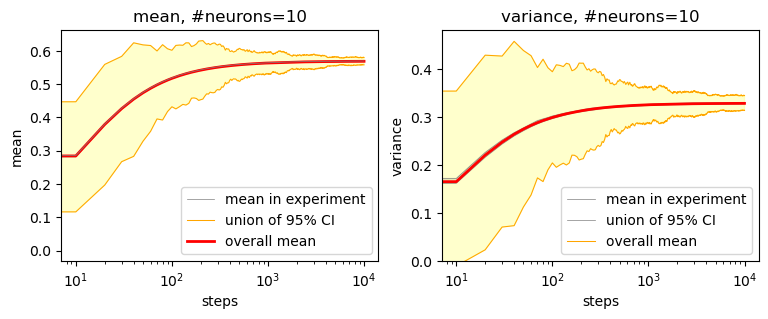

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(9,3))

ax[0].plot(sample * np.arange(1000), lower_mean_h, color="grey", linewidth=.5)
ax[0].plot(sample * np.arange(1000), union_lower_mean_h, color="orange", linewidth=.75)
ax[0].plot(sample * np.arange(1000), overall_cumulative_mean_h, color="red", linewidth=2)
ax[0].plot(sample * np.arange(1000), upper_mean_h, color="grey", linewidth=.5)
ax[0].plot(sample * np.arange(1000), union_upper_mean_h, color="orange", linewidth=.75)
ax[0].fill_between(sample * np.arange(1000), lower_mean_h, upper_mean_h, color="grey", alpha=0.2)
ax[0].fill_between(sample * np.arange(1000), union_lower_mean_h, union_upper_mean_h, color="yellow", alpha=0.2)
ax[0].set_xscale("log")
ax[0].set_xlabel("steps")
ax[0].set_ylabel("mean")
ax[0].set_title("mean, #neurons=10")
ax[0].legend(["mean in experiment", "union of 95% CI", "overall mean"])

ax[1].plot(sample * np.arange(1000), lower_var_h, color="grey", linewidth=.5)
ax[1].plot(sample * np.arange(1000), upper_var_h, color="grey", linewidth=.5)
ax[1].plot(sample * np.arange(1000), union_lower_var_h, color="orange", linewidth=.75)
ax[1].plot(sample * np.arange(1000), union_upper_var_h, color="orange", linewidth=.75)
ax[1].plot(sample * np.arange(1000), overall_cumulative_var_h, color="red", linewidth=2)
ax[1].fill_between(sample * np.arange(1000), lower_var_h, upper_var_h, color="grey", alpha=0.2)
ax[1].fill_between(sample * np.arange(1000), union_lower_var_h, union_upper_var_h, color="yellow", alpha=0.2)
ax[1].set_ylim(0)
ax[1].set_xscale("log")
ax[1].set_xlabel("steps")
ax[1].set_ylabel("variance")
ax[1].set_title("variance, #neurons=10")
ax[1].legend(["mean in experiment", "union of 95% CI", "overall mean"])

case for n_neurons=10, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 187331.53it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:00<00:00, 135127.92it/s]


case for n_neurons=100, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 205217.41it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:00<00:00, 49574.01it/s]


case for n_neurons=1000, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 192144.69it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:01<00:00, 7100.32it/s]


case for n_neurons=10000, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 214005.37it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:17<00:00, 575.50it/s]


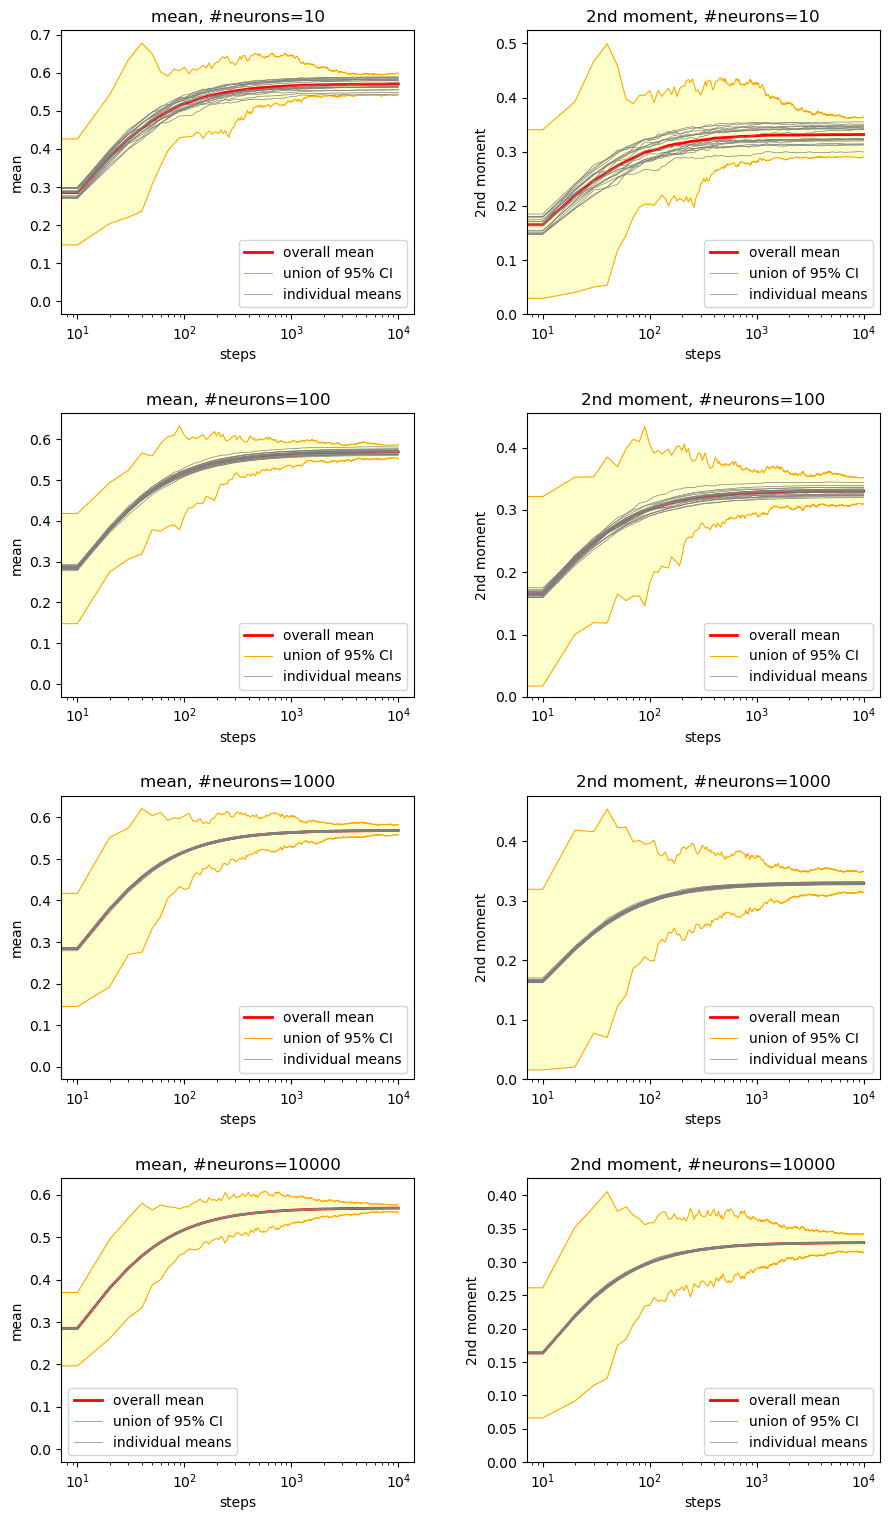

In [31]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(10,12))
fig.tight_layout(pad=5)
n_neurons_arr = [10,100,1000,10000]
max_time_arr = [10000] * 4
sample=10

for i in range(4):
    n_neurons = n_neurons_arr[i]
    simulate_h, _ = simulate_all(n_neurons=n_neurons, T=10, max_time=max_time_arr[i], n_paths=20, store_h_history=True, memorize=True)
    cumulative_mean_h, cumulative_var_h = get_cumulative_moments(simulate_h, sample=sample)
    overall_cumulative_mean_h = cumulative_mean_h.reshape((-1,cumulative_mean_h.shape[2])).mean(axis=0)
    union_lower_mean_h = (cumulative_mean_h.mean(axis=1) - 2 * cumulative_mean_h.std(axis=1)).min(axis=0)
    union_upper_mean_h = (cumulative_mean_h.mean(axis=1) + 2 * cumulative_mean_h.std(axis=1)).max(axis=0)
    overall_cumulative_var_h = cumulative_var_h.reshape((-1,cumulative_var_h.shape[2])).mean(axis=0)
    union_lower_var_h = (cumulative_var_h.mean(axis=1) - 2 * cumulative_var_h.std(axis=1)).min(axis=0)
    union_upper_var_h = (cumulative_var_h.mean(axis=1) + 2 * cumulative_var_h.std(axis=1)).max(axis=0)

    ax[i][0].plot(sample * np.arange(max_time_arr[i] // sample), overall_cumulative_mean_h, color="red", linewidth=2)
    ax[i][0].plot(sample * np.arange(max_time_arr[i] // sample), union_lower_mean_h, color="orange", linewidth=.75)
    ax[i][0].plot(sample * np.arange(max_time_arr[i] // sample), cumulative_mean_h.mean(axis=1).T, color="grey", linewidth=.5)
    ax[i][0].plot(sample * np.arange(max_time_arr[i] // sample), union_upper_mean_h, color="orange", linewidth=.75)
    ax[i][0].fill_between(sample * np.arange(max_time_arr[i] // sample), union_lower_mean_h, union_upper_mean_h, color="yellow", alpha=0.2)
    ax[i][0].set_xscale("log")
    ax[i][0].set_xlabel("steps")
    ax[i][0].set_ylabel("mean")
    ax[i][0].set_title(f"mean, #neurons={n_neurons}")
    ax[i][0].legend(["overall mean", "union of 95% CI", "individual means"])

    ax[i][1].plot(sample * np.arange(max_time_arr[i] // sample), overall_cumulative_var_h, color="red", linewidth=2)
    ax[i][1].plot(sample * np.arange(max_time_arr[i] // sample), union_lower_var_h, color="orange", linewidth=.75)
    ax[i][1].plot(sample * np.arange(max_time_arr[i] // sample), cumulative_var_h.mean(axis=1).T, color="grey", linewidth=.5)
    ax[i][1].plot(sample * np.arange(max_time_arr[i] // sample), union_upper_var_h, color="orange", linewidth=.75)
    ax[i][1].fill_between(sample * np.arange(max_time_arr[i] // sample), union_lower_var_h, union_upper_var_h, color="yellow", alpha=0.2)
    ax[i][1].set_ylim(0)
    ax[i][1].set_xscale("log")
    ax[i][1].set_xlabel("steps")
    ax[i][1].set_ylabel("2nd moment")
    ax[i][1].set_title(f"2nd moment, #neurons={n_neurons}")
    ax[i][1].legend(["overall mean", "union of 95% CI","individual means"])

Now study the histogram of the simulated neurons

In [34]:
simulate_h.shape

(10000, 10000, 20)

case for n_neurons=10, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 210597.69it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:00<00:00, 137936.13it/s]


case for n_neurons=100, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 210460.30it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:00<00:00, 51547.74it/s]


case for n_neurons=1000, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 201560.26it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:01<00:00, 7184.77it/s]


case for n_neurons=10000, max_time=10000
now simulate the underlying chain (x,z)


100%|██████████| 9999/9999 [00:00<00:00, 196117.05it/s]


now simulate the neurons, with history stored


100%|██████████| 9998/9998 [00:18<00:00, 550.20it/s]


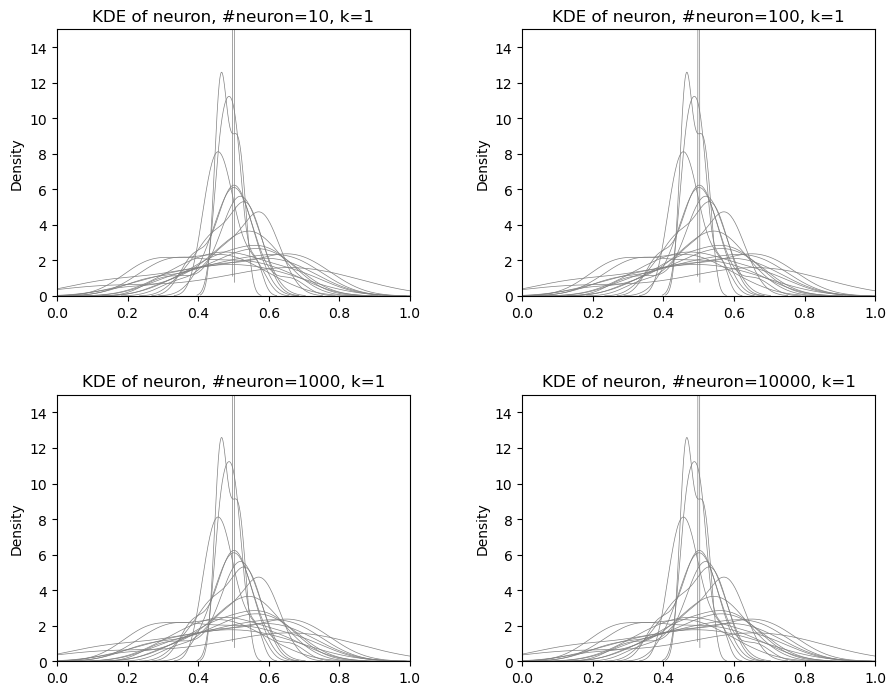

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,8))
fig.tight_layout(pad=5)
n_neurons_arr = np.array([10,100, 1000,10000])
idx_arr = [(0,0), (0,1), (1,0), (1,1)]
sample=10

all_simulate = [simulate_all(n_neurons=n_neurons_arr[i], T=10, max_time=10000, n_paths=20, store_h_history=True, memorize=True)[0] for i in range(4)]

In [16]:
def animate(i, ax, sample=10):

    for j in range(4):
        idx = idx_arr[j]
        ax[idx].cla()

        for path in range(20):
            sns.kdeplot(x=all_simulate[j][sample*i + 1,:,path], ax=ax[idx], color="gray", linewidth=.5)
    
        sns.kdeplot(x=all_simulate[j][sample*i+1].reshape(-1), ax=ax[idx], color="red", linewidth=2)

        ax[idx].set_title(f"KDE of neuron, #neuron={n_neurons_arr[j]}, k={100*i+1}")
        ax[idx].set_xlim([0,1])
        ax[idx].set_ylim([0,15])

ani = FuncAnimation(fig, animate, 99, interval=100, repeat=True, fargs=(ax,100))

In [17]:
HTML(ani.to_html5_video())